In [1]:
from spineq.optimise import get_optimisation_inputs
from spineq.utils import coverage_matrix
from spineq.plotting import plot_optimisation_result
from spineq.data_fetcher import get_oa_shapes, get_oa_centroids

import numpy as np

%matplotlib inline

In [2]:
n_sensors = 20
theta = 500

population_weight = 1
workplace_weight = 0
pop_age_groups = {
    "pop_total": {"min": 0, "max": 90, "weight": 1},
    "pop_children": {"min": 0, "max": 16, "weight": 0},
    "pop_elderly": {"min": 70, "max": 90, "weight": 0},
}

## Get Input Data

In [3]:
data = get_optimisation_inputs(
    population_weight=population_weight,
    workplace_weight=workplace_weight,
    pop_age_groups=pop_age_groups,
    combine=True,
)

data.keys()

dict_keys(['oa11cd', 'oa_x', 'oa_y', 'oa_weight'])

## Calculate Coverage Matrix

Based on distances between each pair of output areas

In [4]:
coverage = coverage_matrix(data["oa_x"], data["oa_y"], theta=theta)
coverage

array([[1.00000000e+00, 2.11181535e-01, 8.34221948e-04, ...,
        1.61147696e-08, 6.12988013e-09, 5.03889214e-11],
       [2.11181535e-01, 1.00000000e+00, 2.91761886e-04, ...,
        7.36465974e-08, 2.85052951e-08, 2.13086224e-10],
       [8.34221948e-04, 2.91761886e-04, 1.00000000e+00, ...,
        2.73136109e-10, 8.01865248e-11, 2.71099036e-12],
       ...,
       [1.61147696e-08, 7.36465974e-08, 2.73136109e-10, ...,
        1.00000000e+00, 2.36019130e-01, 1.21605475e-03],
       [6.12988013e-09, 2.85052951e-08, 8.01865248e-11, ...,
        2.36019130e-01, 1.00000000e+00, 1.16516375e-03],
       [5.03889214e-11, 2.13086224e-10, 2.71099036e-12, ...,
        1.21605475e-03, 1.16516375e-03, 1.00000000e+00]])

In [7]:
dist_sq = np.sum((centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                 axis = -1)

distances = np.sqrt(dist_sq)

Max distance of 16923.71770783074 m is between E00042743 and E00139704


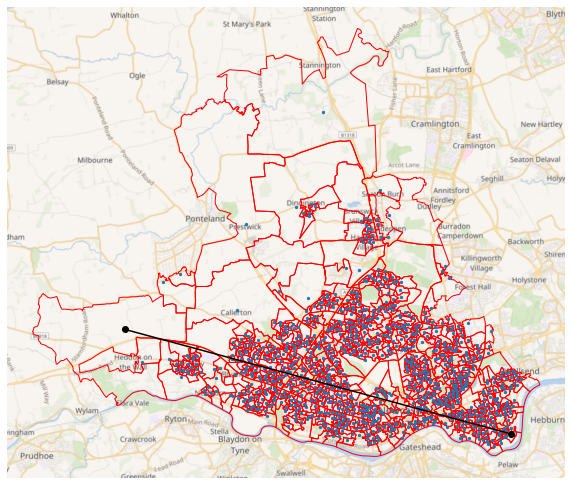

In [8]:
max_idx = np.where(distances == distances.max())[0]
print("Max distance of",
      distances.max(),
      "m is between",
      tyne_oa.iloc[max_idx[0]]["oa11cd"],
      "and", tyne_oa.iloc[max_idx[1]]["oa11cd"])

ax = tyne_oa.plot(figsize=(10,10), facecolor='none', edgecolor='red')
ctx.add_basemap(ax,
                url="https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

x = tyne_oa["X"]
y = tyne_oa["Y"]
ax.scatter(x, y, s=5)

x = tyne_oa.iloc[max_idx]["X"]
y = tyne_oa.iloc[max_idx]["Y"]
ax.plot(x, y, 'k-o')

ax.set_axis_off()

## Calculate "coverage"

coverage at any output area due to a sensor placed in any other output area.

In [9]:
def distance_to_coverage(distance, theta=1):
    return np.exp(- distance / theta)

distance_to_coverage = np.vectorize(distance_to_coverage)

Text(0, 0.5, 'coverage')

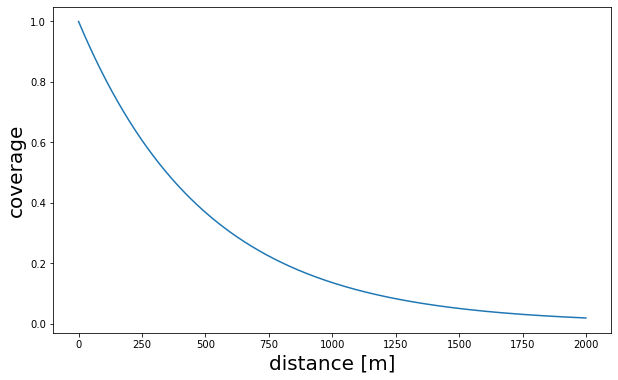

In [10]:
theta = 500

d = np.arange(0, 2000)
plt.figure(figsize=(10,6))
plt.plot(d, distance_to_coverage(d, theta=theta))
plt.xlabel("distance [m]", fontsize=20)
plt.ylabel("coverage", fontsize=20)

#plt.tight_layout()
#plt.savefig("../data/img/coverage_metric.png")

In [11]:
# "coverage" at each output area due to a sensor at any other output area
coverage = distance_to_coverage(distances, theta=theta)

Text(0.5, 1, 'coverage due to sensor at E00042042')

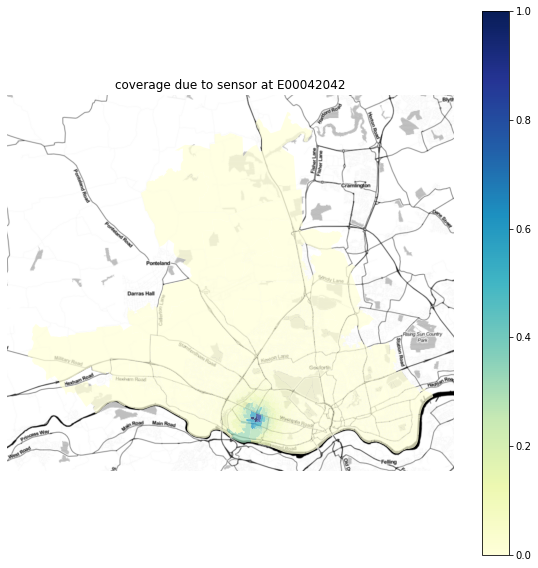

In [12]:
# coverage due to sensor at this output area index
sensor_idx = 0

tyne_oa["coverage"] = coverage[sensor_idx]

ax = tyne_oa.plot(column="coverage",
                  figsize=(10,10),alpha=0.75,
                  cmap="YlGnBu", legend=True)

ctx.add_basemap(ax,
                url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

ax.set_axis_off()
plt.title("coverage due to sensor at " +
          tyne_oa.iloc[sensor_idx]["oa11cd"])

In [13]:
def plot_sensors(sensors,
                 figsize=(20,20),
                 print_sensors=True,
                 save_path=None):
    """
    Plot map with sensor locations (red points), output area centroids (black points),
    and coverage (shaded areas).
    """
    # only keep coverages due to output areas where a sensor is present
    mask_cov = np.multiply(coverage, sensors[np.newaxis, :])

    # coverage at each output area = coverage due to nearest sensor
    max_mask_cov = np.max(mask_cov, axis=1)

    # population weighted average coverage
    avg_coverage = (populations * max_mask_cov).sum() / populations.sum()
    
    tyne_oa["coverage"] = max_mask_cov

    # to make colorbar same size as graph:
    # https://www.science-emergence.com/Articles/How-to-match-the-colorbar-size-with-the-figure-size-in-matpltolib-/
    ax = plt.figure(figsize=figsize).gca()
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    ax = tyne_oa.plot(column="coverage",
                      alpha=0.75,
                      cmap="plasma", legend=True,
                      ax=ax, cax=cax)


    x = tyne_oa[sensors == 1]["X"]
    y = tyne_oa[sensors == 1]["Y"]
    ax.scatter(x, y, s=24, color='r')

    x = tyne_oa[sensors == 0]["X"]
    y = tyne_oa[sensors == 0]["Y"]
    ax.scatter(x, y, s=4, color='k')


    ctx.add_basemap(ax,
                    url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                    crs=tyne_oa.crs)

    ax.set_axis_off()
    ax.set_title("n_sensors = {:.0f}, coverage = {:.2f}".format(sensors.sum(), avg_coverage),
                fontsize=20)
    
    # output areas with sensors
    if print_sensors:
        print("Output areas with sensors:",
              tyne_oa[sensors == 1]["oa11cd"].values)
        
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)

## Baseline 1: place sensors in output areas with largest population

Output areas with sensors: ['E00042147' 'E00042228' 'E00042580' 'E00042600' 'E00042609' 'E00042644'
 'E00042669' 'E00042672' 'E00042673' 'E00042679' 'E00042820' 'E00042877'
 'E00043549' 'E00175564' 'E00175572' 'E00175574' 'E00175578' 'E00175584'
 'E00175591' 'E00175593']


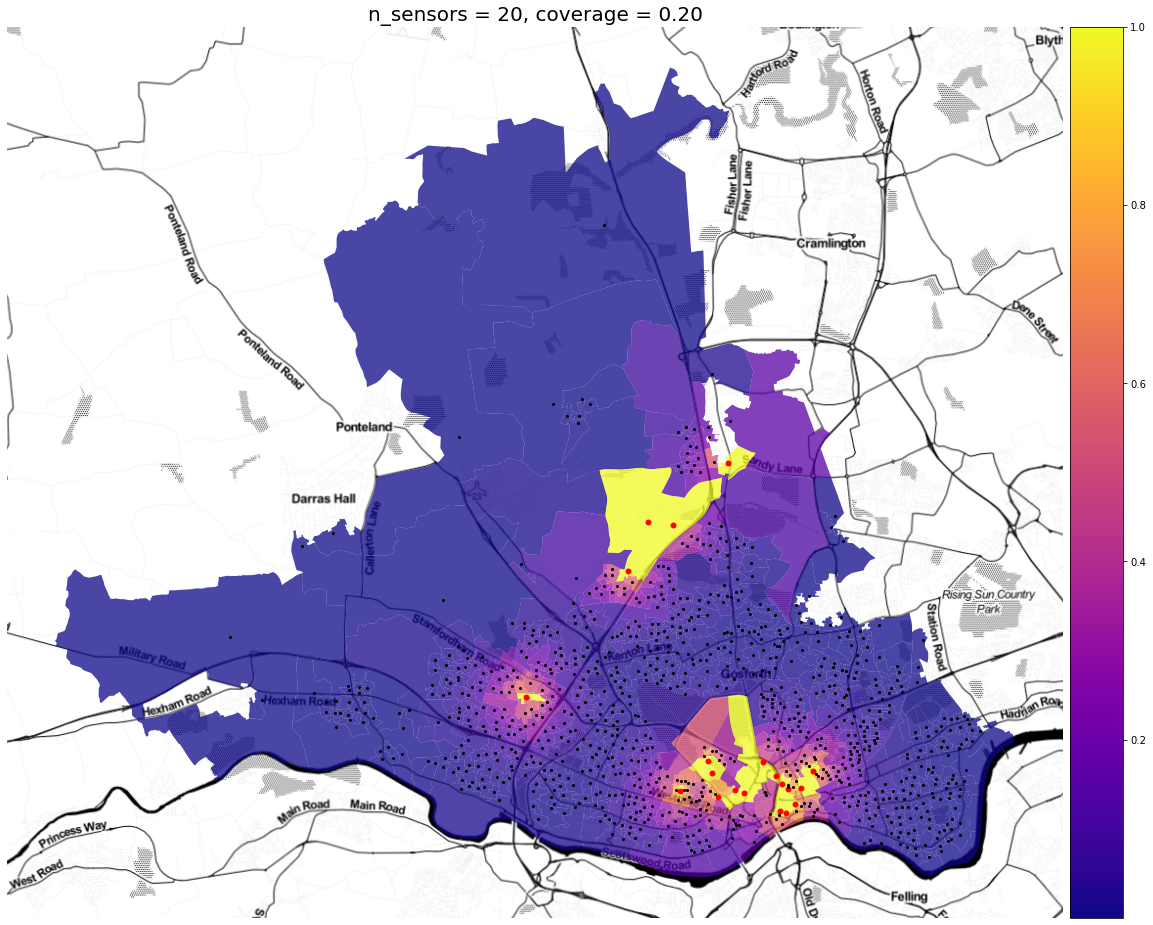

In [14]:
sensors = np.zeros((len(tyne_oa)))

top_idx = tyne_oa["Population"].sort_values(ascending=False).head(n_sensors).index

sensors[top_idx] = 1

plot_sensors(sensors)

## Baseline 2: Place sensors in random output areas

Output areas with sensors: ['E00042043' 'E00042171' 'E00042190' 'E00042251' 'E00042254' 'E00042370'
 'E00042423' 'E00042426' 'E00042438' 'E00042484' 'E00042488' 'E00042620'
 'E00042637' 'E00042704' 'E00042731' 'E00042764' 'E00042834' 'E00042896'
 'E00139797' 'E00175566']


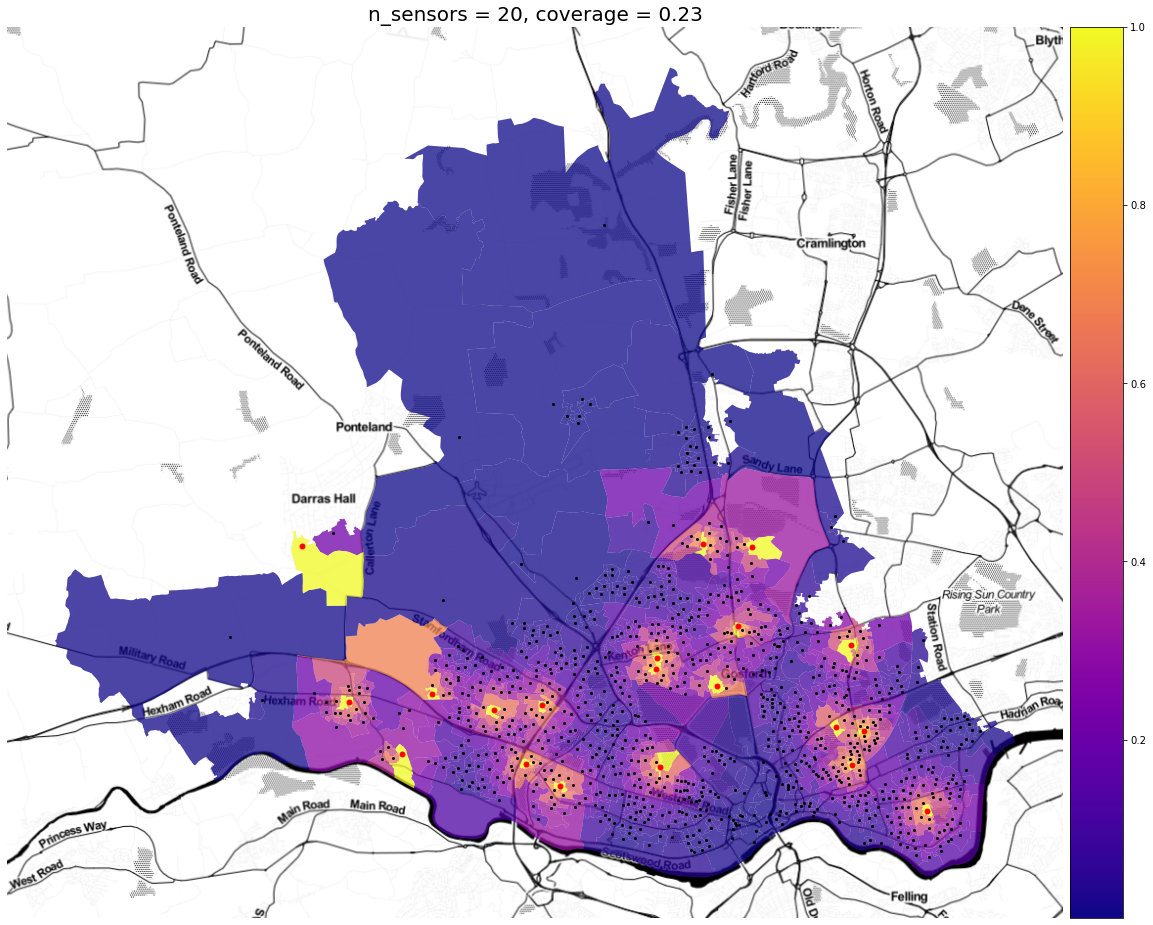

In [15]:
sensors = np.zeros((len(tyne_oa)))

# add sensors at random location
sensor_idx = np.random.randint(0, len(tyne_oa), size=n_sensors)
sensors[sensor_idx] = 1

plot_sensors(sensors)

## Greedy: Place sensors one by one in the place that maximises total coverage

Placing sensor 1 out of 20 ... coverage = 0.04
Placing sensor 2 out of 20 ... coverage = 0.08
Placing sensor 3 out of 20 ... coverage = 0.10
Placing sensor 4 out of 20 ... coverage = 0.12
Placing sensor 5 out of 20 ... coverage = 0.15
Placing sensor 6 out of 20 ... coverage = 0.17
Placing sensor 7 out of 20 ... coverage = 0.19
Placing sensor 8 out of 20 ... coverage = 0.21
Placing sensor 9 out of 20 ... coverage = 0.22
Placing sensor 10 out of 20 ... coverage = 0.23
Placing sensor 11 out of 20 ... coverage = 0.24
Placing sensor 12 out of 20 ... coverage = 0.26
Placing sensor 13 out of 20 ... coverage = 0.27
Placing sensor 14 out of 20 ... coverage = 0.28
Placing sensor 15 out of 20 ... coverage = 0.29
Placing sensor 16 out of 20 ... coverage = 0.30
Placing sensor 17 out of 20 ... coverage = 0.31
Placing sensor 18 out of 20 ... coverage = 0.32
Placing sensor 19 out of 20 ... coverage = 0.33
Placing sensor 20 out of 20 ... coverage = 0.34
DONE!
Average coverage: 0.34


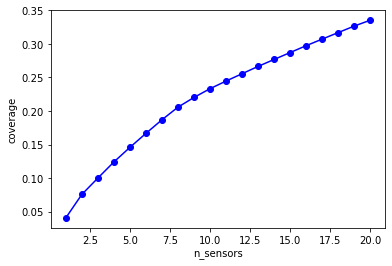

In [16]:
sensors = np.zeros((len(tyne_oa)))
save_plots = False
coverage_history = []
for s in range(n_sensors):
    # greedily add sensors
    print("Placing sensor", s+1, "out of", n_sensors, "... ", end='')
    
    best_coverage = 0
    best_sensors = sensors.copy()
    
    for oa in range(len(tyne_oa)):
        # try adding sensor at each output area
        
        if sensors[oa] == 1:
            # already have a sensor here, so skip to next
            continue
        
        else:
            new_sensors = sensors.copy()
            new_sensors[oa] = 1
            
            # only keep coverages due to output areas where a sensor is present
            mask_cov = np.multiply(coverage, new_sensors[np.newaxis, :])

            # coverage at each output area = coverage due to nearest sensor
            max_mask_cov = np.max(mask_cov, axis=1)
            
            # Avg coverage = population weighted sum across all output areas
            new_coverage = (populations * max_mask_cov).sum() / populations.sum()
            
            if new_coverage > best_coverage:
                # this output area is the best site for next sensor found so far
                best_sensors = new_sensors.copy()
                best_coverage = new_coverage
            
    sensors = best_sensors.copy()
    coverage_history.append(best_coverage)
    print("coverage = {:.2f}".format(best_coverage))
    if save_plots:
        plot_sensors(sensors,
                     save_path="../data/img/nsensors_{:03d}.png".format(s+1),
                     print_sensors=False)
        plt.close('all')

print("DONE!")
print("Average coverage: {:.2f}".format(best_coverage))
plt.plot(range(1,n_sensors+1), coverage_history, '-bo')
plt.xlabel("n_sensors")
plt.ylabel("coverage")
if save_plots:
    plt.savefig("../data/img/coverage.png", dpi=300)

Output areas with sensors: ['E00042043' 'E00042080' 'E00042214' 'E00042255' 'E00042267' 'E00042305'
 'E00042381' 'E00042429' 'E00042447' 'E00042521' 'E00042570' 'E00042621'
 'E00042661' 'E00042662' 'E00042791' 'E00042820' 'E00042846' 'E00042877'
 'E00042886' 'E00175591']


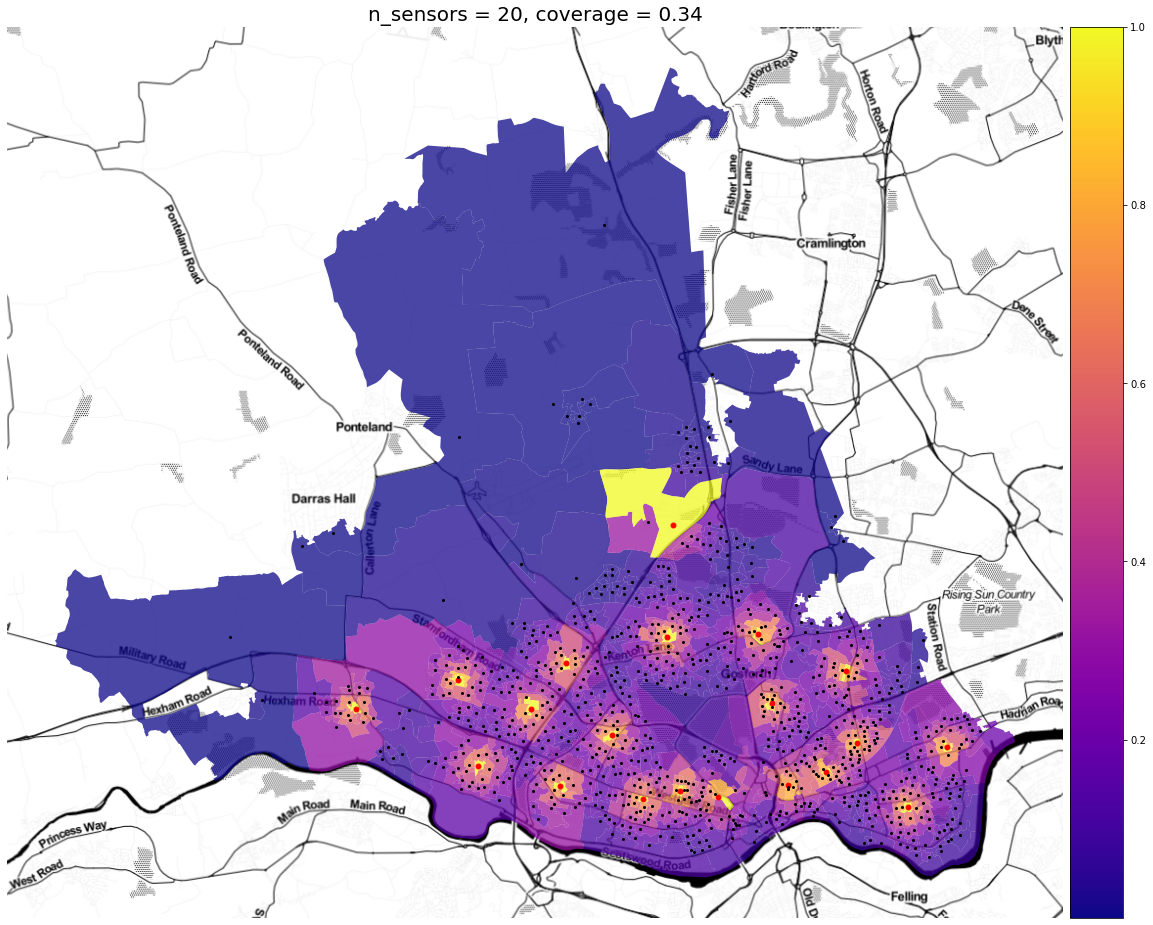

In [17]:
plot_sensors(sensors)

In [18]:
tyne_oa[sensors == 1]["oa11cd"].sort_values()

1      E00042043
36     E00042080
163    E00042214
202    E00042255
214    E00042267
252    E00042305
327    E00042381
375    E00042429
393    E00042447
466    E00042521
515    E00042570
564    E00042621
603    E00042661
604    E00042662
720    E00042791
744    E00042820
769    E00042846
800    E00042877
809    E00042886
937    E00175591
Name: oa11cd, dtype: object

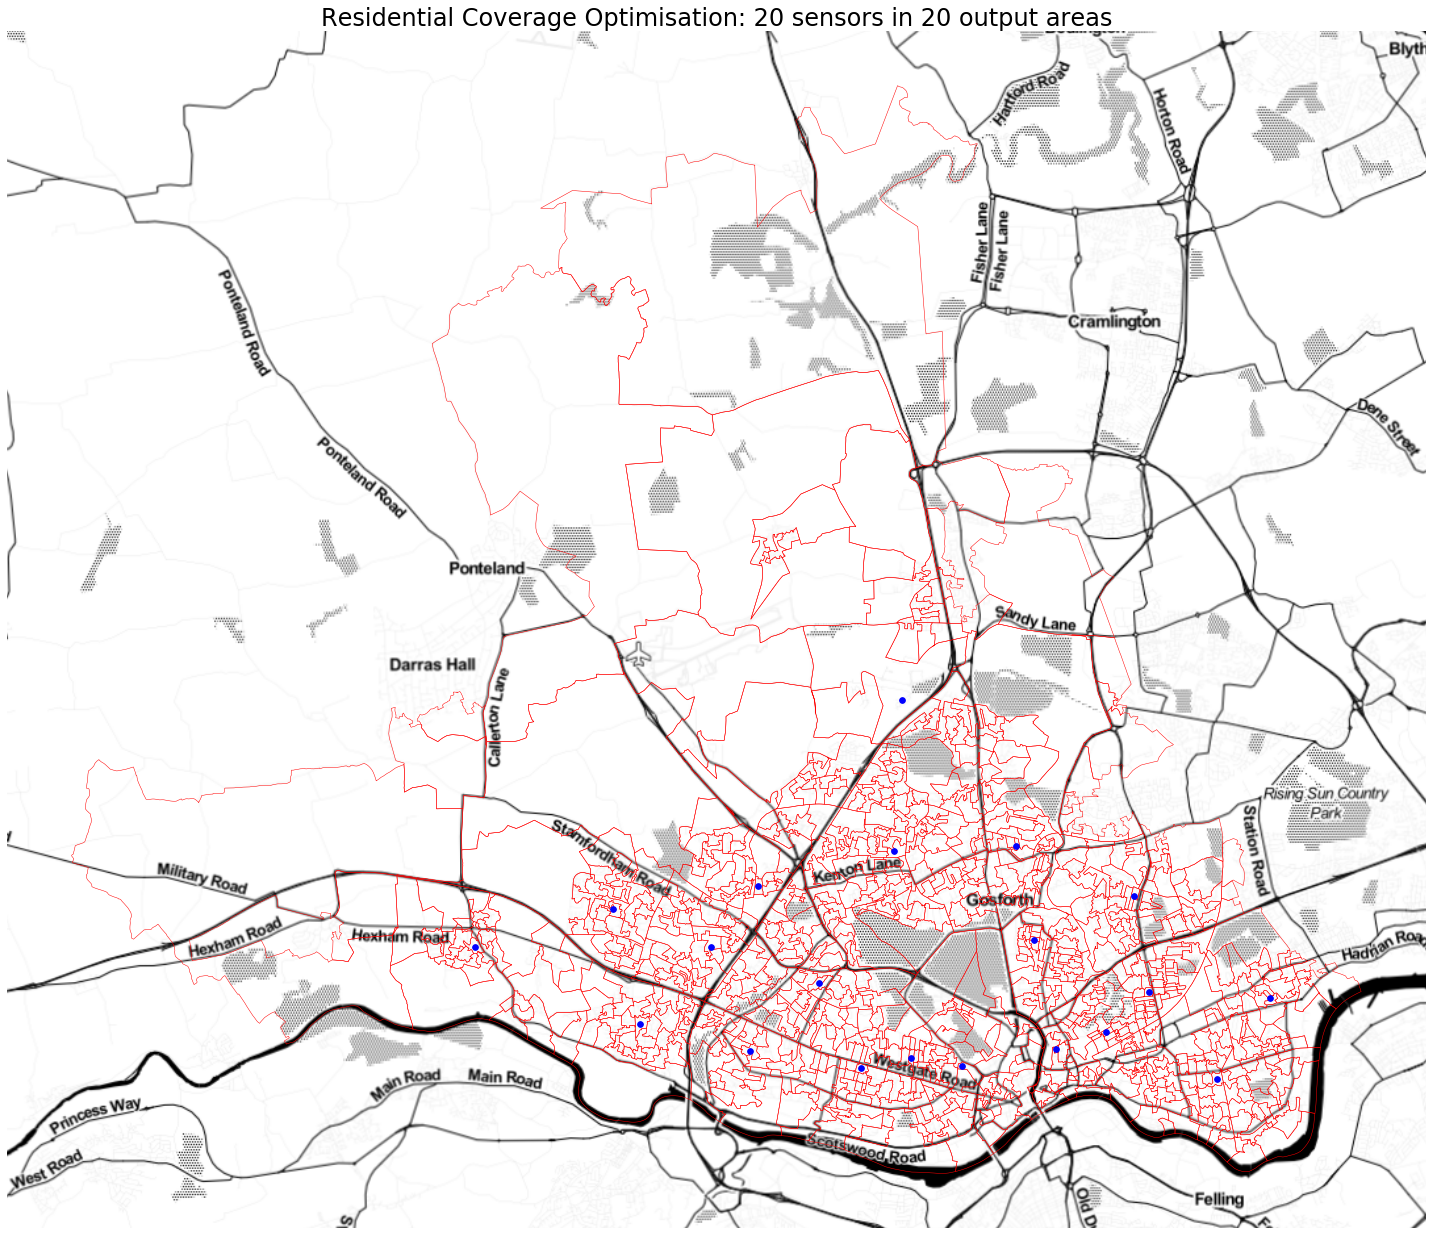

In [19]:
ax = tyne_oa.plot(figsize=(20,20), facecolor='none', edgecolor='red', linewidth=0.5)

ctx.add_basemap(ax,
                #url="https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}.png",
                url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

x = tyne_oa[sensors == 1]["X"]
y = tyne_oa[sensors == 1]["Y"]
ax.scatter(x, y, s=32, color='b')

plt.title("Residential Coverage Optimisation: {} sensors in {} output areas".format(n_sensors, n_sensors),
          fontsize=24)
ax.set_axis_off()

plt.tight_layout()
plt.savefig("../data/img/opt_sensors.png", dpi=300)